# IFRC Projects Analysis - Nepal

This notebook fetches and visualizes project data from the IFRC GO API for Nepal.

## 1. Import Required Libraries

In [1]:
import os
import requests
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import textwrap
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
print('Environment variables loaded successfully!')

Matplotlib is building the font cache; this may take a moment.


Environment variables loaded successfully!


## 2. Define Functions

### 2.1 Fetch Projects from API

In [2]:
def fetchProjects(country_iso3):
    """
    Fetch all projects for a given country from the IFRC GO API.
    
    Args:
        country_iso3: ISO3 country code (e.g., 'NPL' for Nepal)
    
    Returns:
        List of project dictionaries
    """
    base_url = "https://goadmin.ifrc.org/api/v2/project/"
    offset = 0
    page_size = 50
    all_results = []
    
    # Load token from environment variable
    auth_token = os.getenv('IFRC_API_TOKEN')
    
    if not auth_token:
        raise ValueError('IFRC_API_TOKEN not found in environment. Please check your .env file.')

    while True:
        params = {"country_iso3": country_iso3, "offset": offset, "limit": page_size}

        headers = {
            "Authorization": f"Token {auth_token}"
        }

        response = requests.get(base_url, params=params, headers=headers)
        
        # Check for successful response
        if response.status_code != 200:
            print(f"Error: API returned status code {response.status_code}")
            break
            
        data = response.json()
        projects = data.get("results", [])

        if not projects:
            # No more results, break the loop
            break

        # Add fetched projects to the results list
        all_results.extend(projects)

        # Increment offset for the next page
        offset += page_size

    return all_results

### 2.2 Process Project Data

In [3]:
def getDataFromProjects(projects):
    """
    Extract and count projects by primary sector and programme type.
    
    Args:
        projects: List of project dictionaries
    
    Returns:
        Tuple of (sorted_primary_sectors dict, sector_programme_counter dict)
    """
    primary_sector_counter = Counter()
    sector_programme_counter = Counter()

    for project in projects:
        # Count projects by primary sector
        primary_sector = project.get("primary_sector_display", "Unknown")
        primary_sector_counter[primary_sector] += 1
        programme_type = project.get("programme_type_display", "Unknown")
        sector_programme_counter[programme_type] += 1

    # Sort primary sectors by count in descending order
    sorted_primary_sectors = dict(
        sorted(primary_sector_counter.items(), key=lambda x: x[1], reverse=True)
    )

    return sorted_primary_sectors, sector_programme_counter

### 2.3 Helper Function for Label Wrapping

In [4]:
def wrap_labels(labels, width=15):
    """
    Wrap text labels to a specified width for better display.
    
    Args:
        labels: List of label strings
        width: Maximum width before wrapping (default: 15)
    
    Returns:
        List of wrapped label strings
    """
    wrapped_labels = [textwrap.fill(label, width) for label in labels]
    return wrapped_labels

### 2.4 Visualization Functions

In [5]:
def plotPrimarySectors(primary_sectors_data):
    """
    Create a bar chart showing projects by primary sector.
    
    Args:
        primary_sectors_data: Dictionary with sector names as keys and counts as values
    """
    labels, values = zip(*primary_sectors_data.items())
    wrapped_labels = wrap_labels(labels)
    
    # Custom color palette
    custom_colors = [
        "#0d6abf",
        "#73361c",
        "#eb895f",
        "#893395",
        "#d64550",
        "#73361c",
        "#f0e199",
    ]
    
    # Extend colors if needed
    while len(custom_colors) < len(labels):
        custom_colors.extend(custom_colors)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(wrapped_labels)), values, color=custom_colors[:len(labels)], align="center")

    # Add data labels on top of bars
    for index, value in enumerate(values):
        plt.text(
            index, value + 0.05, str(value), ha="center", va="bottom", fontsize=10
        )

    plt.xlabel("Primary Sectors", fontsize=14)
    plt.xticks(
        range(len(wrapped_labels)), wrapped_labels, rotation=0, ha="center", fontsize=11
    )
    plt.yticks(fontsize=12)
    plt.ylabel("Number of Projects", fontsize=14)
    plt.title("Projects in Nepal by Sectors", fontsize=16)
    plt.grid(True, axis="y", linestyle="dotted", alpha=0.5, color="black")

    plt.tight_layout()
    plt.show()

### 2.5 DataFrame Creation Function

In [6]:
def projects_dataframe(all_results):
    """
    Convert project data to a pandas DataFrame with selected columns.
    
    Args:
        all_results: List of project dictionaries
    
    Returns:
        pandas DataFrame with primary_sector_display and programme_type_display columns
    """
    selected_columns = ["primary_sector_display", "programme_type_display"]
    projects_data = []

    for project in all_results:
        selected_data = {key: project.get(key, None) for key in selected_columns}
        projects_data.append(selected_data)
    
    return pd.DataFrame(projects_data)

## 3. Fetch and Process Data

In [7]:
# Fetch projects for Nepal
projects = fetchProjects("NPL")
print(f"Total projects fetched: {len(projects)}")

Total projects fetched: 66


In [8]:
# Process data - call getDataFromProjects only once (fix for duplicate call)
sorted_primary_sectors, programme_type = getDataFromProjects(projects)

print("Primary Sectors:")
for sector, count in sorted_primary_sectors.items():
    print(f"  {sector}: {count}")

print("\nProgramme Types:")
for ptype, count in programme_type.items():
    print(f"  {ptype}: {count}")

Primary Sectors:
  WASH: 48
  Health (public): 10
  Livelihoods and basic needs: 3
  CEA: 2
  PGI: 1
  Shelter: 1
  NS Strengthening: 1

Programme Types:
  Bilateral: 57
  Multilateral: 9


## 4. Visualization

### 4.1 Bar Chart - Projects by Primary Sector

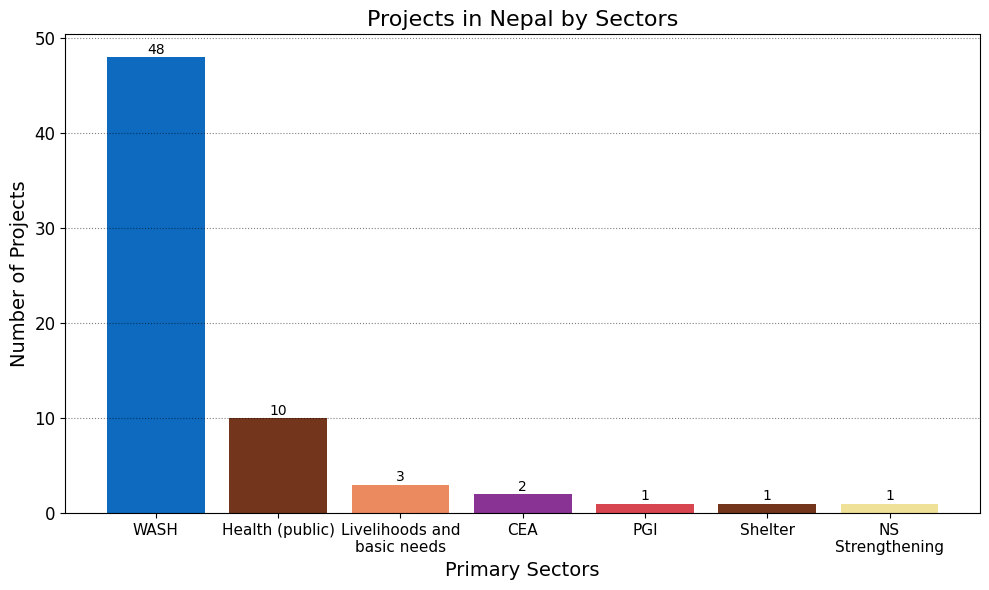

In [9]:
# Plot primary sectors bar chart
plotPrimarySectors(sorted_primary_sectors)

### 4.2 Stacked Bar Chart - Projects by Sector and Programme Type

In [10]:
# Create DataFrame
df = projects_dataframe(projects)
print(f"DataFrame shape: {df.shape}")
df.head()

DataFrame shape: (66, 2)


,primary_sector_display,programme_type_display
0,WASH,Bilateral
1,WASH,Bilateral
2,WASH,Bilateral
3,WASH,Bilateral
4,WASH,Multilateral


In [11]:
# Group and sort data
grouped_df = (
    df.groupby(["primary_sector_display", "programme_type_display"])
    .size()
    .reset_index(name="count")
)

sorted_df = (
    grouped_df.groupby("primary_sector_display")["count"]
    .sum()
    .reset_index()
    .sort_values(by="count", ascending=False)
)

print("Grouped data:")
grouped_df

Grouped data:


,primary_sector_display,programme_type_display,count
0,CEA,Bilateral,2
1,Health (public),Bilateral,8
2,Health (public),Multilateral,2
3,Livelihoods and basic needs,Bilateral,2
4,Livelihoods and basic needs,Multilateral,1
5,NS Strengthening,Bilateral,1
6,PGI,Multilateral,1
7,Shelter,Multilateral,1
8,WASH,Bilateral,44
9,WASH,Multilateral,4


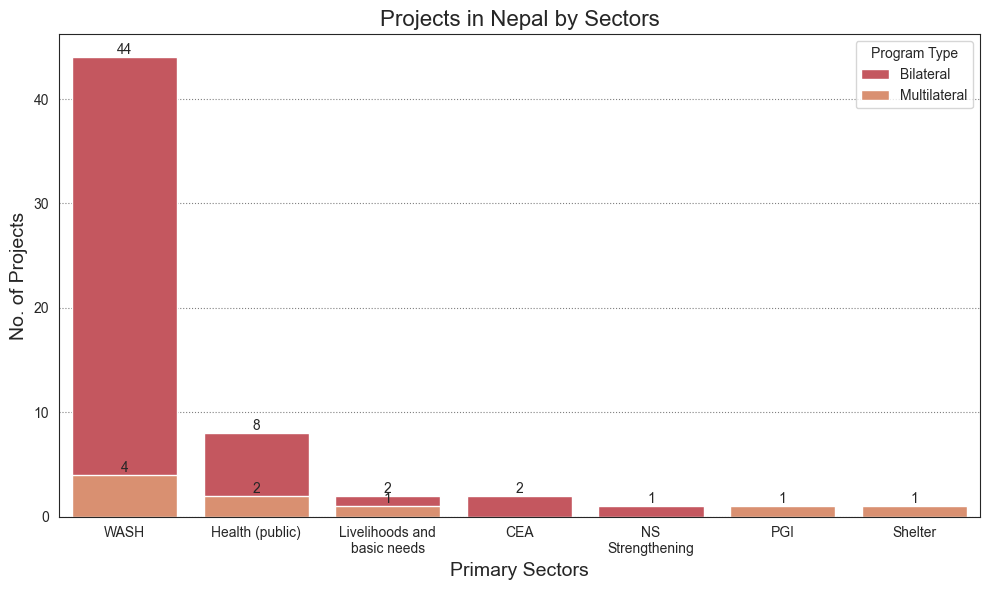

In [12]:
# Custom color palette for programme types
custom_palette = ["#d64550", "#eb895f"]

# Create the plot
plt.figure(figsize=(10, 6))
sns.set_style("white")  # Use set_style instead of deprecated set(style=...)

ax = sns.barplot(
    x="primary_sector_display",
    y="count",
    hue="programme_type_display",
    data=grouped_df,
    palette=custom_palette,
    dodge=False,
    order=sorted_df["primary_sector_display"],
)

# Add annotations to all bars (fixed: iterate all patches)
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate bars with height > 0
        width = p.get_width()
        x, y = p.get_xy()
        ax.annotate(f"{height:.0f}", (x + width / 2, y + height), ha="center", va="bottom")

# Wrap x tick labels (fixed: use range for positions)
tick_labels = list(sorted_df["primary_sector_display"])
wrapped_labels = [textwrap.fill(label, width=15) for label in tick_labels]
plt.xticks(range(len(wrapped_labels)), wrapped_labels, rotation=0, ha="center")

# Add legend and labels
plt.legend(loc="upper right", title="Program Type")
plt.xlabel("Primary Sectors", fontsize=14)
plt.ylabel("No. of Projects", fontsize=14)
plt.title("Projects in Nepal by Sectors", fontsize=16)
plt.grid(True, axis="y", linestyle="dotted", alpha=0.5, color="black")

plt.tight_layout()
plt.show()

## 5. Summary

This notebook:
1. Fetches project data from the IFRC GO API for Nepal (ISO3: NPL)
2. Processes and counts projects by primary sector and programme type
3. Visualizes the data using:
   - A simple bar chart showing project counts by sector
   - A grouped bar chart showing the breakdown by programme type within each sector